# Winter Shortfall Events

We investigate extreme winter shortfall weather events (from the Adverse Weather Scenarios for Future Electricity Systems dataset)

We compare our data to ERA5 reanalysis weather data, ERA5 reanalysis converted demand data, and to UREAD energy variables. 

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

##  Pre-processed data

To generate this data, run `process_events.py`

This converts the ERA5 reanalysis (hourly) gridded data, and the extreme weather events (daily) gridded data into daily national UK aggregate, with demand, windpower

In [11]:
# ERA5
demand_reanalysis = xr.open_dataset('data/ds_reanalysis.nc')

# Most extreme winter drought events 1/2/3
demand_scenarios = {s: xr.open_dataset(f'data/ds_scenario_{s}.nc')
                    for s in [1, 2, 3]}

# All return period events
demand_return = {p: {s: xr.open_dataset(f'data/ds_event{s}_return{p}.nc') for s in [1,2,3]}
                 for p in [2,5,10,50,100]}

## Metadata

Metadata from the original extreme weather event files was not saved (todo! include this in the processed data).

Instead we load it here - this contains the start date and duration of extreme event

In [3]:
# Most extreme duration

# Read event files (for metadata)
data_loc = '/badc/deposited2021/adverse_met_scenarios_electricity/data/'
fpaths = {s: data_loc + f'winter_wind_drought/uk/most_extreme_events/duration/event{s}/'
         for s in demand_scenarios}

metadata = dict()
for s, fpath in fpaths.items():
    ds = xr.open_dataset(fpath+f'winter_wind_drought_uk_most_extreme_events_duration_event{s}_tas.nc')
    metadata[s] = ds.attrs

event_calendar = dict()
for s, md in metadata.items():
    date_start = dt.datetime.strptime(md['Event start date'], '%Y-%m-%d')
    duration = int(md['Event duration'].split(' ')[0])
    date_end = date_start + dt.timedelta(days=duration)
    event_calendar[s] = pd.date_range(date_start, date_end)

In [31]:
# Return periods

# Read event files (for metadata)
data_loc = '/badc/deposited2021/adverse_met_scenarios_electricity/data/'
fpaths = {p: {s: data_loc + f'winter_wind_drought/uk/return_period_1_in_{p}_years/duration/gwl12-4degC/event{s}/'
         for s in demand_scenarios} for p in demand_return}

metadata = dict()
for p, fpath_dict in fpaths.items():
    metadata[p] = dict()
    for s, fpath in fpath_dict.items():
        ds = xr.open_dataset(fpath+f'winter_wind_drought_uk_return_period_1_in_{p}_years_duration_gwl12-4degC_event{s}_tas.nc')
        metadata[p][s] = ds.attrs

event_calendar_return = dict()
for p, mdp in metadata.items():
    event_calendar_return[p] = dict()
    for s, md in mdp.items():
        date_start = dt.datetime.strptime(md['Event start date'], '%Y-%m-%d')
        duration = int(md['Event duration'].split(' ')[0])
        date_end = date_start + dt.timedelta(days=duration)
        event_calendar_return[p][s] = pd.date_range(date_start, date_end)

## UREAD Energy Variables

As an additional comparison, load the UREAD energy variables dataset

In [4]:
# Read UREAD energy vars
data_loc = '/gws/pw/j05/cop26_hackathons/oxford/Data/UREAD_energy_timeseries/'
fpath_demand = data_loc + 'demand_model_outputs/ERA5_full_demand_all_countries_1979_2019_hourly.csv'
fpath_windpower = data_loc + 'wind_power_model_outputs/ERA5_whh_all_countries_1979_2019_inclusive_hourly.csv'

# Read in demand, windpower
dataset_demand = pd.read_csv(fpath_demand, index_col=0)['United_Kingdom_full_hourly_1979_2019.dat']
dataset_windpower = pd.read_csv(fpath_windpower, index_col=0)['ERA5_native_grid_United_Kingdom_whh_weighted_1979_2019_v16_hourly.dat']

ds_uread = pd.DataFrame({'demand': dataset_demand, 'windpower': dataset_windpower})

## Weather variables: most extreme events vs. ERA5 reanalysis distribution

/opt/jaspy/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/jaspy/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


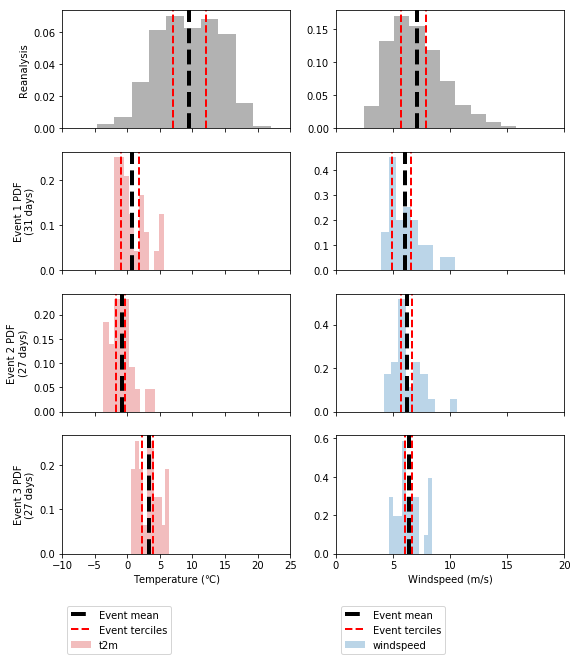

In [6]:
fig, axs = plt.subplots(4, 2, figsize=(9,10), sharex='col')

# TEMPERATURE
# Histogram of reanalysis temperature
labels = ['Reanalysis'] + [f'Event {s} PDF\n({len(event_calendar[s])} days)'
                           for s in demand_scenarios]
t2m_array = [demand_reanalysis.t2m] + \
    [ds.t2m.loc[e] for e, ds in zip(event_calendar.values(), demand_scenarios.values())]

hist_kwargs = [dict(color='k', alpha=0.3, density=True)] + \
              [dict(color='tab:red', alpha=0.3, density=True)]*3

for label, t2m, ax, hkwarg in zip(labels, t2m_array, axs[:, 0], hist_kwargs):
    # event span
    ax.hist(t2m, **hkwarg)
    ax.axvline(t2m.mean(), color='k', ls='--', lw=4, label='Event mean')
    ax.axvline(t2m.quantile(1/3), color='r', ls='--', lw=2, label='Event terciles')
    ax.axvline(t2m.quantile(2/3), color='r', ls='--', lw=2, label=None)

    ax.set_ylabel(label)

axs[-1, 0].set_xlabel('Temperature (℃)')
axs[-1, 0].legend(bbox_to_anchor=(0,-0.4), loc="upper left")
axs[-1, 0].set_xlim(-10, 25)

# WINDSPEED
# Histogram of reanalysis windspeed
w_array = [demand_reanalysis.windspeed] + \
    [ds.windspeed.loc[e] for e, ds in zip(event_calendar.values(), demand_scenarios.values())]

hist_kwargs = [dict(color='k', alpha=0.3, density=True)] + \
              [dict(color='tab:blue', alpha=0.3, density=True)]*3

for w, ax, hkwarg in zip(w_array, axs[:, 1], hist_kwargs):
    # event span
    ax.hist(w, **hkwarg)
    ax.axvline(w.mean(), color='k', ls='--', lw=4, label='Event mean')
    ax.axvline(w.quantile(1/3), color='r', ls='--', lw=2, label='Event terciles')
    ax.axvline(w.quantile(2/3), color='r', ls='--', lw=2, label=None)

axs[-1, 1].set_xlim(0, 20)
axs[-1, 1].set_xlabel('Windspeed (m/s)')
axs[-1, 1].legend(bbox_to_anchor=(0,-0.4), loc="upper left")

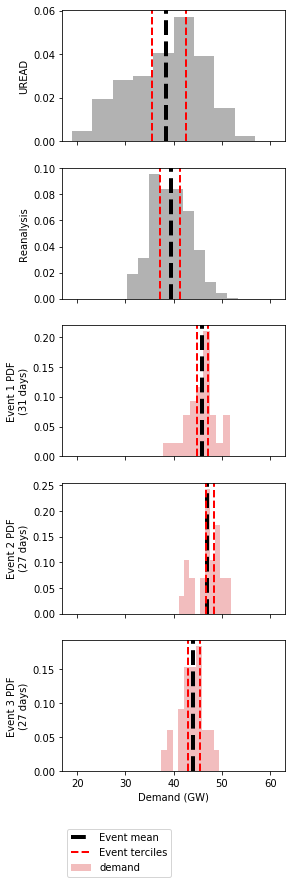

In [7]:
fig, axs = plt.subplots(5, 1, figsize=(4,14), sharex='col')

# DEMAND
# Histogram of reanalysis demand
labels = ['UREAD'] + ['Reanalysis'] + \
    [f'Event {s} PDF\n({len(event_calendar[s])} days)' for s in demand_scenarios]
t2m_array = [ds_uread.demand] + [demand_reanalysis.demand] + \
    [ds.demand.loc[e] for e, ds in zip(event_calendar.values(), demand_scenarios.values())]

hist_kwargs = [dict(color='k', alpha=0.3, density=True)]*2 + \
              [dict(color='tab:red', alpha=0.3, density=True)]*3

for label, t2m, ax, hkwarg in zip(labels, t2m_array, axs, hist_kwargs):
    # event span
    ax.hist(t2m, **hkwarg)
    ax.axvline(t2m.mean(), color='k', ls='--', lw=4, label='Event mean')
    ax.axvline(t2m.quantile(1/3), color='r', ls='--', lw=2, label='Event terciles')
    ax.axvline(t2m.quantile(2/3), color='r', ls='--', lw=2, label=None)

    ax.set_ylabel(label)

axs[-1].set_xlabel('Demand (GW)')
axs[-1].legend(bbox_to_anchor=(0,-0.4), loc="upper left")
#axs[-1, 0].set_xlim(-10, 25)

# Return period events

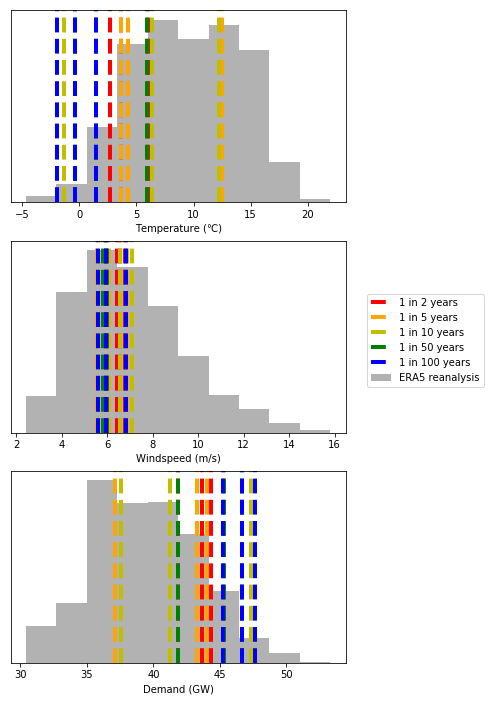

In [50]:
# mean

fig, axs = plt.subplots(3, figsize=(6,12))

variables = ['t2m', 'windspeed', 'demand']
xlabels = ['Temperature (℃)', 'Windspeed (m/s)', 'Demand (GW)']

for ax, var, xlabel in zip(axs, variables, xlabels):

    ax.hist(demand_reanalysis[var], color='k', alpha=0.3, density=True, label='ERA5 reanalysis')
    colors = ['r', 'orange', 'y', 'g', 'b']

    for p, ds, color in zip(demand_return.keys(), demand_return.values(), colors):
        labels = [f'1 in {p} years', None, None]
        for e, dse in ds.items():
            dates = event_calendar_return[p][e]
            y = dse[var].loc[dates]
            ax.axvline(y.mean(), lw=4, ls='--', color=color, label=labels.pop(0))

    ax.set_xlabel(xlabel)
    ax.set_yticks([])
axs[1].legend(bbox_to_anchor=(1.05,0.75), loc="upper left")

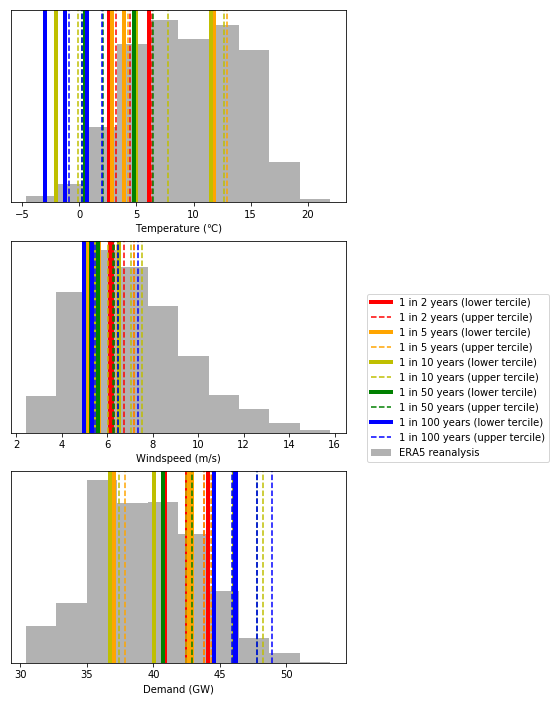

In [60]:
# terciles

fig, axs = plt.subplots(3, figsize=(6,12))

variables = ['t2m', 'windspeed', 'demand']
xlabels = ['Temperature (℃)', 'Windspeed (m/s)', 'Demand (GW)']

for ax, var, xlabel in zip(axs, variables, xlabels):

    ax.hist(demand_reanalysis[var], color='k', alpha=0.3, density=True, label='ERA5 reanalysis')
    colors = ['r', 'orange', 'y', 'g', 'b']

    for p, ds, color in zip(demand_return.keys(), demand_return.values(), colors):
        labels = [f'1 in {p} years', None, None]
        for e, dse in ds.items():
            dates = event_calendar_return[p][e]
            y = dse[var].loc[dates]
            l = labels.pop(0)
            l1, l2 = None, None
            if l is not None:
                l1 = f'{l} (lower tercile)'
                l2 = f'{l} (upper tercile)'
            ax.axvline(y.quantile(1/3), lw=4, ls='-', color=color, label=l1)
            ax.axvline(y.quantile(2/3), lw=1.5, ls='--', color=color, label=l2)

    ax.set_xlabel(xlabel)
    ax.set_yticks([])
axs[1].legend(bbox_to_anchor=(1.05,0.75), loc="upper left")